In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

# 1. Softmax & Cross entropy loss

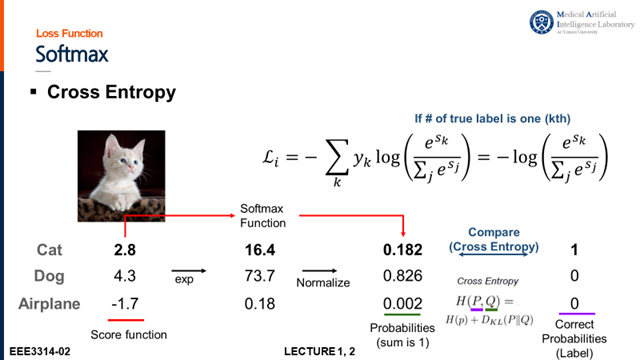

In [ ]:
def get_softmax(x): # calculate softmax values
  return np.exp(x)/np.sum(np.exp(x), axis=0) 

  '''
  multiple samples인 경우 고려해서 axis=0 
  입력이 다차원 ex. 10 x 1000 -> 10개의 class로만 합을 하고, 1000은 무시
  -> 안하면 1000개 samples에 대한 모든 sum 값이 분모로 들어가서 발산함

  '''

In [ ]:
def Loss_softmax(s, y):
  # Cross entropy loss calculation
  [num_class, num_sample] = s.shape
  Li = 0
  for i in range(num_sample):
    ysample = y[:,i] # 특정 sample의 label
    ssample = s[:,i] # 특정 sample의 score 
    softmax_value = get_softmax(ssample)
    Li += np.sum(-np.log(softmax_value)*ysample)
  return (Li / num_sample) # 모든 sample에 대한 loss 값의 평균

In [ ]:
def Loss_reg(W, dim=2):
    if dim == 1: # L1 regularization:
        reg = np.sum(abs(W))
    elif dim == 2: # L2 regularization:
        reg = np.sum(W**2)

    return reg

In [ ]:
# the number of sample = 1

num_size = 4
num_class = 3
num_sample = 1

# y = Wx + b

x = np.random.randint(255, size = (num_size, num_sample)) # Input (size 4 x 1)
W = np.random.normal(0, 0.01, size = (num_class, num_size)) # Weights (size 3 x 4)
b = np.random.normal(0, 1, size = (num_class, num_sample)) # bias (size 3 x 1)

s = np.dot(W, x) + b # Score (size 3x1)
y = np.array([1, 0, 0])[..., np.newaxis] # label

print(x, '<-- x')
print(W, '<-- W')
print(b, '<-- b')
print(s, '<-- s')
print(y, '<-- y')

In [ ]:
print(np.round(get_softmax(s), 5), '<-- softmax value')
print('CE(softmax) loss :', np.round(Loss_softmax(s, y),5))

In [ ]:
np.sum(get_softmax(s))

## MNIST case

In [ ]:
import sklearn.datasets
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [ ]:
num_sample = 5000
num_class = 10

x_data = mnist.data[:num_sample].T
x_data = x_data/np.max(x_data)
img_size = x_data[:,0].size
y_index = mnist.target[:num_sample]

y = np.zeros((num_class, num_sample))
for idx in range(num_sample):
    y[int(y_index[idx]), idx] = 1    

x = np.reshape(x_data, (-1, num_sample)) # Input (size 784 x 5000) --> (image_size x sample)
W = np.random.normal(0, 0.001, size = (num_class, img_size)) # Weights (size 10 x 784) --> (class x image_size)
b = np.random.normal(0, 0.1, size = (num_class, num_sample)) # bias (size 10 x 5000) --> (class x sample)

s = np.dot(W, x) + b # Score (size 10 x 5000)

In [ ]:
print(x_data.shape)
print(img_size) # 28*28*1
print(s.shape)

In [ ]:
y.shape
y

In [ ]:
softmax = np.round(get_softmax(s),5)
loss_term = np.round(Loss_softmax(s, y),5)
reg_term_r2 = np.round(Loss_reg(W, dim=2),5)

print('loss_term :', loss_term) 
print('r2_regularization :', reg_term_r2) 
print('total loss :', loss_term + 0.01*reg_term_r2)

In [ ]:
print(softmax.shape)
print(sum(softmax[:,1]))

# 2. MLP and backpropagation implementation with **Numpy** library using MNIST dataset


In [ ]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [ ]:
import numpy as np
import sklearn.datasets

mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [ ]:
print(mnist.data.shape) # num_sample x data_size (70000 x 784)

In [ ]:
# data preprocessing (데이터 전처리) for overfitting 방지

num_train = 60000
num_class = 10

x_train = np.float32(mnist.data[:num_train]).T # 60000개
y_train_index = np.int32(mnist.target[:num_train]).T # one-hot encoding 아닌 그냥 숫자
x_test = np.float32(mnist.data[num_train:]).T # 10000개
y_test_index = np.int32(mnist.target[num_train:]).T

# Normalization (0~1) 8bit
x_train /= 255
x_test /= 255
x_size = x_train.shape[0] # 784

# one hot encoding
y_train = np.zeros((num_class, y_train_index.shape[0]))
for idx in range(y_train_index.shape[0]):
  y_train[y_train_index[idx], idx] = 1  

y_test = np.zeros((num_class, y_test_index.shape[0]))
for idx in range(y_test_index.shape[0]):
  y_test[y_test_index[idx], idx] = 1    

In [ ]:
print(x_train.shape) # 60000개
print(x_test.shape)  # 10000개
print(y_train.shape) # one-hot encoding 결과
print(y_test.shape)

In [ ]:
#parameter initialization
hidden_size = 64 

# two-layer neural network
# y = np.dot(W1, x) => np.random.randn(output, input)  
params = {"W1": np.random.randn(hidden_size, x_size) * np.sqrt(1/ x_size), # np.random.randn : random gaussian distribution  # np.sqrt(1/ x_size) : Xavier initialization
          "b1": np.zeros((hidden_size, 1)) * np.sqrt(1/ x_size),
          "W2": np.random.randn(num_class, hidden_size) * np.sqrt(1/ hidden_size),
          "b2": np.zeros((num_class, 1)) * np.sqrt(1/ hidden_size)}
     
# Xavier initialization: https://reniew.github.io/13/ 
# w = np.random.randn(n_input, n_output) / sqrt(n_input)
# np.random.randn(hidden_size, x_size) * np.sqrt(1/ x_size)

# He initialization: https://gomguard.tistory.com/184 
# w = np.random.randn(n_input, n_output) / sqrt(n_input/2)

In [ ]:
def sigmoid(x): # Activation function for Forward Pass
    return 1/(1+np.exp(-x))

def d_sigmoid(x):  # Derivative of A.f for Backward Pass
    exp = np.exp(-x)
    return (exp)/((1+exp)**2) # derivative of sigmoid

def softmax(x):  # Score function
    exp = np.exp(x)
    return exp/np.sum(exp, axis=0)

In [ ]:
def compute_loss(y_true, y_pred):
  num_sample = y_true.shape[1]
  Li = -1 * np.sum(y_true * np.log(y_pred))  
     # -1 * sum( true label * log(softmax value) )
  return Li/num_sample

In [ ]:
def foward_pass(x, params):
  
  params["S1"] = np.dot(params["W1"], x) + params["b1"] # y = Wx + b ... first score
  params["A1"] = sigmoid(params["S1"]) # A1 = act(Wx+b) ## Activation function 수정!
  params["S2"] = np.dot(params["W2"], params["A1"]) + params["b2"]
  params["A2"] = softmax(params["S2"]) # softmax 거쳐서 최종 결과
  ## S3, A3 추가

  return params

In [ ]:
def foward_pass_test(x, params):

  params_test = {}
  
  params_test["S1"] = np.dot(params["W1"], x) + params["b1"]
  params_test["A1"] = sigmoid(params_test["S1"])
  params_test["S2"] = np.dot(params["W2"], params_test["A1"]) + params["b2"]
  params_test["A2"] = softmax(params_test["S2"])
  ## S3, A3 추가

  return params_test

In [ ]:
def compute_accuracy(y_true, y_pred):
  y_true_idx = np.argmax(y_true, axis = 0) # 제일 큰 값의 index
  y_pred_idx = np.argmax(y_pred, axis = 0)
  num_correct = np.sum(y_true_idx == y_pred_idx)

  accuracy = num_correct / y_true.shape[1] * 100

  return accuracy

In [ ]:
def backward_pass(x, y_true, params):

  dS2 = params["A2"] - y_true
  # dS2 is softmax + CE loss derivative
  # Please check http://machinelearningmechanic.com/deep_learning/2019/09/04/cross-entropy-loss-derivative.html

  grads = {}

  grads["dW2"] =  np.dot(dS2, params["A1"].T)/x.shape[1]  # dS2 : upstream gradient
  grads["db2"] =  np.sum(dS2, axis=1, keepdims=True)/x.shape[1]

  dA1 = np.dot(params["W2"].T, dS2) # 2nd linear classifiter의 input(1st의 output)의 미분값
  dS1 = dA1 * d_sigmoid(params["S1"]) # score function의 미분값

  grads["dW1"] = np.dot(dS1, x.T)/x.shape[1]
  grads["db1"] = np.sum(dS1, axis=1, keepdims=True)/x.shape[1]

  # grads[] 에서 /x.shape[1] : normalization ....모든 sample에 대한 gradient의 sum으로 인한 발산 방지 위해 sample 개수로 나눔

  # Please check http://cs231n.stanford.edu/handouts/linear-backprop.pdf

  return grads

In [ ]:
epochs = 100
learning_rate = 0.5  ## 튜닝 

for i in range(epochs):

  if i == 0:
    params = foward_pass(x_train, params)
    
  grads = backward_pass(x_train, y_train, params)

  # params updated by negative direction
  params["W1"] -= learning_rate * grads["dW1"]
  params["b1"] -= learning_rate * grads["db1"]
  params["W2"] -= learning_rate * grads["dW2"]
  params["b2"] -= learning_rate * grads["db2"]

  params = foward_pass(x_train, params)
  train_loss = compute_loss(y_train, params["A2"])
  train_acc = compute_accuracy(y_train, params["A2"])

  params_test = foward_pass_test(x_test, params)
  test_loss = compute_loss(y_test, params_test["A2"])
  test_acc = compute_accuracy(y_test, params_test["A2"])

  print("Epoch {}: training loss = {}, training acuracy = {}%, test loss = {}, test acuracy = {}%"
  .format(i + 1, np.round(train_loss, 6), np.round(train_acc, 2), np.round(test_loss, 6), np.round(test_acc, 2)))

  # training acc와 test acc가 같이 올라가므로 overfitting X
  # training acc는 굉장히 높은데 test acc가 낮다면 overfitting 일어난 것

  # Epoch 1 에서 Softmax classifier의 Sanity check : log(class_num) = log(10) ~= 2.3

# Assignment

## Assignment 2-1
ReLu activation function을 구현해보세요

- Hint : np.maximum 함수 사용하면 편리합니다
- 다른 방법 사용하셔도 무방합니다


In [ ]:
def relu(x):
  return np.maximum(0,x)

##Assignment 2-2
ReLu의 derivative function을 구현해보세요


In [ ]:
def d_relu(x):
  return 1 * (x > 0)

## Assignment 2-3
Lecture 2의 2. Backpropagation with numpy 코드 참고해서
Three layer MLP를 구한후, 학습을 돌려 보세요

hyperparameter는 다음과 같이 설정

- <#> of train data, <#> of test data : 60000, 10000
- epochs : 100
- hiddensize : 128, 64 (two layer)
- learning_rate : 0.5

In [ ]:
import numpy as np
import sklearn.datasets

mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [ ]:
# Three layer MLP

# Data Pre-processing
num_train = 60000
num_class = 10
x_train = np.float32(mnist.data[:num_train]).T # 60000
y_train_index = np.int32(mnist.target[:num_train]).T 
x_test = np.float32(mnist.data[num_train:]).T # 10000
y_test_index = np.int32(mnist.target[num_train:]).T

# Normalization (0~1)
x_train /= 255
x_test /= 255
x_size = x_train.shape[0]

# one hot encoding
y_train = np.zeros((num_class, y_train_index.shape[0]))
for idx in range(y_train_index.shape[0]):
  y_train[y_train_index[idx], idx] = 1
y_test = np.zeros((num_class, y_test_index.shape[0]))
for idx in range(y_test_index.shape[0]):
  y_test[y_test_index[idx], idx] = 1    

# parameter initialization
hidden_size_1 = 128 # 1st hidden unit size
hidden_size_2 = 64 # 1st hidden unit size

# y = np.dot(W1, x) => np.random.randn(output, input)
# np.random.randn : random gaussian distribution  # np.sqrt(1/ x_size) : Xavier initialization
params = {"W1": np.random.randn(hidden_size_1, x_size) * np.sqrt(1/ x_size),
          "b1": np.zeros((hidden_size_1, 1)) * np.sqrt(1/ x_size),
          "W2": np.random.randn(hidden_size_2, hidden_size_1) * np.sqrt(1/ hidden_size_1),
          "b2": np.zeros((hidden_size_2, 1)) * np.sqrt(1/ hidden_size_1),
          "W3": np.random.randn(num_class, hidden_size_2) * np.sqrt(1/ hidden_size_2),
          "b3": np.zeros((num_class, 1)) * np.sqrt(1/ hidden_size_2) 
          # adding W3, b3 for implementing 3-layer MLP
          }

# functions
def sigmoid(x): # Activation function for Forward Pass
  return 1/(1+np.exp(-x))

def d_sigmoid(x):  # Derivative of A.f for Backward Pass
  exp = np.exp(-x)
  return (exp)/((1+exp)**2) # derivative of sigmoid

def softmax(x): # Score function
  exp = np.exp(x)
  return exp/np.sum(exp, axis=0)

# loss calculation
def compute_loss(y_true, y_pred):
  num_sample = y_true.shape[1]
  Li = -1 * np.sum(y_true * np.log(y_pred))  # -1 * sum( true label * log(softmax value) ) 
  return Li/num_sample

def foward_pass(x, params):
  params["S1"] = np.dot(params["W1"], x) + params["b1"] # S1 = W1x + b1 ..first score
  params["A1"] = sigmoid(params["S1"]) # A1 = act(W1x + b1) ..first activation function value
  params["S2"] = np.dot(params["W2"], params["A1"]) + params["b2"] # S2 = W2A1 + b2 ..second score
  params["A2"] = sigmoid(params["S2"]) # A2 = act(W2A1 + b2) ..second activation function value
  params["S3"] = np.dot(params["W3"], params["A2"]) + params["b3"] # S3 = W3A2 + b3 ..third score
  params["A3"] = softmax(params["S3"]) # A3 = act(W3A2 + b3) ..final value after passing softmax
  return params

def foward_pass_test(x, params):
  params_test = {}
  params_test["S1"] = np.dot(params["W1"], x) + params["b1"]
  params_test["A1"] = sigmoid(params_test["S1"])
  params_test["S2"] = np.dot(params["W2"], params_test["A1"]) + params["b2"]
  params_test["A2"] = sigmoid(params_test["S2"])
  params_test["S3"] = np.dot(params["W3"], params_test["A2"]) + params["b3"] 
  params_test["A3"] = softmax(params_test["S3"]) 
  # adding S3, A3 for implementing 3-layer MLP
  return params_test

def compute_accuracy(y_true, y_pred):
  y_true_idx = np.argmax(y_true, axis = 0)
  y_pred_idx = np.argmax(y_pred, axis = 0)
  num_correct = np.sum(y_true_idx==y_pred_idx)
  accuracy = num_correct / y_true.shape[1] * 100
  return accuracy

def backward_pass(x, y_true, params):
  dS3 = params["A3"] - y_true # softmax + CE loss derivative
  grads = {}

  grads["dW3"] =  np.dot(dS3, params["A2"].T)/x.shape[1] # dS3 : upstream gradient
  grads["db3"] =  np.sum(dS3, axis=1, keepdims=True)/x.shape[1]
  
  dA2 = np.dot(params["W3"].T, dS3) # linear classifiter의 input derivative
  dS2 = dA2 * d_sigmoid(params["S2"]) # score function derivative

  grads["dW2"] = np.dot(dS2, params["A1"].T)/x.shape[1] # dS2 : upstream gradient
  grads["db2"] = np.sum(dS2, axis=1, keepdims=True)/x.shape[1]

  dA1 = np.dot(params["W2"].T, dS2) # linear classifiter의 input derivative
  dS1 = dA1 * d_sigmoid(params["S1"]) # score function derivative

  grads["dW1"] = np.dot(dS1, x.T)/x.shape[1] # dS1 : upstream gradient
  grads["db1"] = np.sum(dS1, axis=1, keepdims=True)/x.shape[1]
  # /x.shape[1]: normalization (sample number로 나눔) 모든 samples gradient sum으로 인한 발산 방지
  return grads

# train and test
epochs = 100
learning_rate = 0.5  

for i in range(epochs):
  if i == 0:
    params = foward_pass(x_train, params)
  grads = backward_pass(x_train, y_train, params)

  # params updated by negative direction
  params["W1"] -= learning_rate * grads["dW1"]
  params["b1"] -= learning_rate * grads["db1"]
  params["W2"] -= learning_rate * grads["dW2"]
  params["b2"] -= learning_rate * grads["db2"]
  params["W3"] -= learning_rate * grads["dW3"]
  params["b3"] -= learning_rate * grads["db3"]
  
  # chaning params["A2"] to params["A3"]
  params = foward_pass(x_train, params)
  train_loss = compute_loss(y_train, params["A3"])
  train_acc = compute_accuracy(y_train, params["A3"])
  params_test = foward_pass_test(x_test, params)
  test_loss = compute_loss(y_test, params_test["A3"])
  test_acc = compute_accuracy(y_test, params_test["A3"])

  print("Epoch {}: training loss = {}, training acuracy = {}%, test loss = {}, test acuracy = {}%"
  .format(i + 1, np.round(train_loss, 6), np.round(train_acc, 2), np.round(test_loss, 6), np.round(test_acc, 2)))


Epoch 1: training loss = 2.304975, training acuracy = 15.55%, test loss = 2.304195, test acuracy = 16.46%
Epoch 2: training loss = 2.295316, training acuracy = 11.24%, test loss = 2.294963, test acuracy = 11.35%
Epoch 3: training loss = 2.292901, training acuracy = 11.24%, test loss = 2.292525, test acuracy = 11.35%
Epoch 4: training loss = 2.290735, training acuracy = 11.24%, test loss = 2.290322, test acuracy = 11.35%
Epoch 5: training loss = 2.288558, training acuracy = 11.24%, test loss = 2.288108, test acuracy = 11.35%
Epoch 6: training loss = 2.286362, training acuracy = 11.24%, test loss = 2.285875, test acuracy = 11.36%
Epoch 7: training loss = 2.284144, training acuracy = 11.24%, test loss = 2.283619, test acuracy = 11.36%
Epoch 8: training loss = 2.281899, training acuracy = 11.25%, test loss = 2.281336, test acuracy = 11.36%
Epoch 9: training loss = 2.279624, training acuracy = 11.26%, test loss = 2.279023, test acuracy = 11.38%
Epoch 10: training loss = 2.277315, training a

## Assignment 2-4
Lecture 2의 2. backpropagatin with numpy 부분의 성능을 지금까지 배운 지식을 바탕으로 향상시켜보세요

- Hint : Activation function, hyperparameter setting

In [ ]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

import numpy as np
import sklearn.datasets

mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")

In [ ]:
# Layer number : Two layer MLP
# data preprocessing 
num_train = 60000
num_class = 10

x_train = np.float32(mnist.data[:num_train]).T # 60000
y_train_index = np.int32(mnist.target[:num_train]).T
x_test = np.float32(mnist.data[num_train:]).T # 10000
y_test_index = np.int32(mnist.target[num_train:]).T

# Normalization
x_train /= 255
x_test /= 255
x_size = x_train.shape[0]

# one hot encoding
y_train = np.zeros((num_class, y_train_index.shape[0]))
for idx in range(y_train_index.shape[0]):
  y_train[y_train_index[idx], idx] = 1

y_test = np.zeros((num_class, y_test_index.shape[0]))
for idx in range(y_test_index.shape[0]):
  y_test[y_test_index[idx], idx] = 1    

# parameter initialization
# hidden size tuning : 64 --> 768
hidden_size = 768 # hidden unit size

# Weight initialization : Xavier initialization --> He initialization
# y = np.dot(W1, x) => np.random.randn(output, input)
# np.random.randn : random gaussian distribution 
# * np.sqrt(2/ x_size) : He initialization 
params = {"W1": np.random.randn(hidden_size, x_size) * np.sqrt(2/ x_size),
          "b1": np.zeros((hidden_size, 1)) * np.sqrt(2/ x_size),
          "W2": np.random.randn(num_class, hidden_size) * np.sqrt(2/ x_size),
          "b2": np.zeros((num_class, 1)) * np.sqrt(2/ x_size) 
          }

# Activation function and derivative of it : sigmoid, d_sigmoid --> relu, d_relu
def relu(x):
  return np.maximum(0,x)

def d_relu(x):
  return 1 * (x > 0)

def softmax(x):  # Score function
    exp = np.exp(x)
    return exp/np.sum(exp, axis=0)

def compute_loss(y_true, y_pred):
  num_sample = y_true.shape[1]
  Li = -1 * np.sum(y_true * np.log(y_pred))
  return Li/num_sample 

def foward_pass(x, params):
  params["S1"] = np.dot(params["W1"], x) + params["b1"] 
  params["A1"] = relu(params["S1"]) 
  params["S2"] = np.dot(params["W2"], params["A1"]) + params["b2"]
  params["A2"] = softmax(params["S2"]) 
  return params

def foward_pass_test(x, params):
  params_test = {}
  params_test["S1"] = np.dot(params["W1"], x) + params["b1"]
  params_test["A1"] = relu(params_test["S1"])
  params_test["S2"] = np.dot(params["W2"], params_test["A1"]) + params["b2"]
  params_test["A2"] = softmax(params_test["S2"])
  return params_test

def compute_accuracy(y_true, y_pred):
  y_true_idx = np.argmax(y_true, axis = 0)
  y_pred_idx = np.argmax(y_pred, axis = 0)
  num_correct = np.sum(y_true_idx==y_pred_idx)
  accuracy = num_correct / y_true.shape[1] * 100
  return accuracy

def backward_pass(x, y_true, params):
  dS2 = params["A2"] - y_true # softmax + CE loss derivative
  grads = {}
  grads["dW2"] =  np.dot(dS2, params["A1"].T)/x.shape[1]
  grads["db2"] =  np.sum(dS2, axis=1, keepdims=True)/x.shape[1]
  dA1 = np.dot(params["W2"].T, dS2) 
  dS1 = dA1 * d_relu(params["S1"]) 
  grads["dW1"] = np.dot(dS1, x.T)/x.shape[1]
  grads["db1"] = np.sum(dS1, axis=1, keepdims=True)/x.shape[1]
  return grads

# epochs number : 100 --> 300
epochs = 300

# learning rate tuning
learning_rate = 0.8 

for i in range(epochs):

  if i == 0:
    params = foward_pass(x_train, params)
    
  grads = backward_pass(x_train, y_train, params)

  # params updated by negative direction
  params["W1"] -= learning_rate * grads["dW1"]
  params["b1"] -= learning_rate * grads["db1"]
  params["W2"] -= learning_rate * grads["dW2"]
  params["b2"] -= learning_rate * grads["db2"]

  params = foward_pass(x_train, params)
  train_loss = compute_loss(y_train, params["A2"])
  train_acc = compute_accuracy(y_train, params["A2"])

  params_test = foward_pass_test(x_test, params)
  test_loss = compute_loss(y_test, params_test["A2"])
  test_acc = compute_accuracy(y_test, params_test["A2"])

  print("Epoch {}: training loss = {}, training acuracy = {}%, test loss = {}, test acuracy = {}%"
  .format(i + 1, np.round(train_loss, 6), np.round(train_acc, 2), np.round(test_loss, 6), np.round(test_acc, 2)))


Epoch 1: training loss = 2.615497, training acuracy = 26.74%, test loss = 2.624671, test acuracy = 26.85%
Epoch 2: training loss = 2.980046, training acuracy = 43.52%, test loss = 3.005126, test acuracy = 43.88%
Epoch 3: training loss = 2.290634, training acuracy = 47.32%, test loss = 2.318286, test acuracy = 47.09%
Epoch 4: training loss = 1.523486, training acuracy = 55.73%, test loss = 1.511704, test acuracy = 55.7%
Epoch 5: training loss = 1.177308, training acuracy = 69.08%, test loss = 1.164223, test acuracy = 68.99%
Epoch 6: training loss = 0.923973, training acuracy = 75.03%, test loss = 0.90463, test acuracy = 75.46%
Epoch 7: training loss = 0.754472, training acuracy = 84.1%, test loss = 0.732403, test acuracy = 85.11%
Epoch 8: training loss = 0.66165, training acuracy = 83.79%, test loss = 0.638924, test acuracy = 84.63%
Epoch 9: training loss = 0.626084, training acuracy = 84.58%, test loss = 0.604081, test acuracy = 85.26%
Epoch 10: training loss = 0.709779, training acura

**무엇을 보완하였고, 왜 보완되었는지에 대한 자유 서술 (아래에)**


#### 1. Layer number : Two layer MLP
- [ Two layer MLP ] Epoch 100: training loss = 0.506211, training acuracy = 87.67%, test loss = 0.487152, test acuracy = 88.39%
- [ Three layer MLP ] Epoch 100: training loss = 1.326667, training acuracy = 66.93%, test loss = 1.314322, test acuracy = 67.7%
> 앞선 문항을 통해 Two layer MLP에서 Three layer MLP로 변경하였을 경우 최종적인 training accuraccy와 test accurcay가 모두 감소하였음을 관찰하였기에 layer의 수를 늘리지 않고 기존의 Two layer MLP를 사용하였다. 단순히 hidden layer의 수를 늘려 신경망을 깊게 한다고 해서 모델의 분류 성능이 올라가는 것이 아니며, 이는 신경망이 깊을수록 가중치가 조금이라도 달라지면 같은 입력 값을 갖더라도 가중치의 변화에 의해 완전히 다른 값을 얻을 수 있기 때문이라고 예상하였다. 이를 통해 데이터의 특성을 파악하여 적절한 신경망 깊이를 구성하는 것이 중요하다는 것을 알 수 있었다.

#### 2. Activation function : sigmoid, d_sigmoid --> relu, d_relu
- [ sigmoid ] Epoch 100: training loss = 0.506211, training acuracy = 87.67%, test loss = 0.487152, test acuracy = 88.39%
- [ relu ] Epoch 100: training loss = 0.289871, training acuracy = 91.73%, test loss = 0.281209, test acuracy = 91.93%
> sigmoid function은 input x가 너무 크거나 작아서 saturated될 경우 downstream gradient가 0이 되어 hidden layer가 거의 동작하지 않아 update가 잘 안되는 큰 문제가 있다. 또한, sigmoid의 값은 항상 양수이기에 sigmoid의 gradient 값도 항상 양수가 되어 모든 gradients가 같은 부호를 갖게 되어 weights가 같은 방향으로만 수렴하게 된다. 추가로, exponential function의 경우 expensive하다는 문제도 있다. 따라서 input이 0 이상인 경우 saturated 되지 않으며 계산적으로도 효율적이며 더 빠르게 수렴하는 relu function을 사용하였다. 그 결과, 최종 test accurcay가 약 3.5% 증가하였다. (88.39% -> 91.93%)

#### 3. Weight initialization : Xavier initialization --> He initialization
- [ Xavier initialization ] Epoch 100: training loss = 0.289871, training acuracy = 91.73%, test loss = 0.281209, test acuracy = 91.93%
- [ He initialization ] Epoch 100: training loss = 0.268187, training acuracy = 92.36%, test loss = 0.25624, test acuracy = 92.63%
> ReLU function을 activation function으로 사용할 때 Xavier initialization을 사용하면 weights의 분포 대부분이 0이 되어 출력 값이 0으로 수렴하게 되어 비효율적인 결과(Collapsing)를 보이게 된다. ReLU function은 음의 영역이 0이기에 더 넓게 분포시키기 위해 2배의 계수가 필요하다. 따라서 ReLU function에 특화된 He initialization (Xaiver with  1/2)을 사용했으며 그 결과, 최종 test accurcay가 증가함을 확인할 수 있었다. (91.93% -> 92.63% )

#### 4. Hidden size tuning : 64 --> 768
- [ Hidden_size = 64 ] Epoch 100: training loss = 0.268187, training acuracy = 92.36%, test loss = 0.25624, test acuracy = 92.63%
- [ Hidden_size = 512 ] Epoch 100: training loss = 0.252847, training acuracy = 92.98%, test loss = 0.244663, test acuracy = 93.16%
- [ Hidden_size = 768 ] Epoch 100: training loss = 0.244228, training acuracy = 93.21%, test loss = 0.238967, test acuracy = 93.28%
- [ Hidden_size = 1024 ] Epoch 100: training loss = 0.237691, training acuracy = 93.4%, test loss = 0.231245, test acuracy = 93.65%
- [ Hidden_size = 2048 ] Epoch 100: training loss = 0.225585, training acuracy = 93.81%, test loss = 0.220107, test acuracy = 93.93%
> hidden layer size를 너무 작게 하면 모델이 너무 간단해져 복잡한 데이터셋의 경우에는 그 특징을 잘 잡아내지 못해 학습이 잘 안되는 underfitting이 일어날 수 있다. 반면에 hidden layer size를 너무 크게 하면 training data에만 지나치게 적응되어 그 외의 간단한 test data에 대해서도 구분을 잘 못하는 overfitting이 발생할 수 있으며 훈련 시간 또한 증가한다. 따라서 경험을 통해 수치를 바꿔가며 적절한 hidden size를 결정하는 과정이 필요하다. Hidden size hyperparameter tuning은 '512'부터 시작하였으며 이는 '(2/3)*(x_size = 784) + (num_class = 10) ~= 532 ~= 512'를 통해 결정했다. 여러 번의 시도를 통해 위와 같이 hidden size를 높일수록 정확도가 높아지는 것을 관찰할 수 있었다. 그러나 '2048'과 같이 size가 너무 큰 경우에는 정확도의 미미한 향상 정도에 비해 1 epoch당 소요 시간이 길어 전체 훈련 시간이 너무 오래 걸렸다. 따라서 훈련에 사용할 최종 hidden size는 정확도가 높으면서도 훈련 시간이 너무 오래 소요되지 않는 (100 epoch당 약 12분 소요) '768'로 결정하였다. 향후 Mini-batch Gradient Descent 등의 방법을 사용한다면 이 문제를 해결할 수 있을 것으로 기대된다.

#### 5. Learning rate tuning
- [ learning_rate = 0.01 ] Epoch 100: training loss = 1.334839, training acuracy = 73.76%, test loss = 1.309104, test acuracy = 75.28%
- [ learning_rate = 0.1 ] Epoch 100: training loss = 0.417164, training acuracy = 89.16%, test loss = 0.39547, test acuracy = 89.79%
- [ learning_rate = 0.3 ] Epoch 100: training loss = 0.294708, training acuracy = 91.84%, test loss = 0.284082, test acuracy = 92.18%
- [ learning_rate = 0.5 ] Epoch 100: training loss = 0.244228, training acuracy = 93.21%, test loss = 0.238967, test acuracy = 93.28%
- [ learning_rate = 0.6 ] Epoch 100: training loss = 0.224634, training acuracy = 93.75%, test loss = 0.218703, test acuracy = 93.96%
- [ learning_rate = 0.7 ] Epoch 100: training loss = 0.213278, training acuracy = 94.05%, test loss = 0.208362, test acuracy = 94.04%
- [ learning_rate = 0.8 ] Epoch 100: training loss = 0.197887, training acuracy = 94.48%, test loss = 0.191529, test acuracy = 94.73%
- [ learning_rate = 0.9 ~ ] : overshooting problem
> learning rate란 gradient의 방향으로 얼마나 빠르게 이동할 것인지를 결정하는 hyperparameter이다. 너무 작으면 학습의 속도가 느려지며 local minima에 빠질 위험이 있다. 반대로 너무 크면 수렴하지 않고 진동하는 overshooting이 발생할 수 있다. learning_rate를 '5.0'으로 설정하였을 때에는 RuntimeWarning이 발생했으며 '0.9' 이상에 대해서는 overshooting 현상이 관찰되었다. 여러 번의 시도를 통해 overshooting이 발생하지 않으면서 test acuracy(94.73%)가 가장 높게 나온 '0.8'을 최적의 learning rate로 선정했다.

#### 6. epochs number : 100 --> 300
- [ epochs = 100 ] Epoch 100: training loss = 0.197887, training acuracy = 94.48%, test loss = 0.191529, test acuracy = 94.73%
- [ epochs = 200 ] Epoch 200: training loss = 0.137406, training acuracy = 96.2%, test loss = 0.142986, test acuracy = 95.78%
- [ epochs = 300 ] Epoch 300: training loss = 0.109147, training acuracy = 97.08%, test loss = 0.118026, test acuracy = 96.54%
> 신경망에서 순전파와 역전파를 거쳐 전체 데이터셋에 대하여 1회 학습하는 것을 1epoch이라고 한다. epoch number 또한 조절 가능한 하이퍼파라미터에 포함된다. epoch number를 늘리면 정확도가 높아질 것이라고 예상할 수 있지만, 너무 지나치면 overfitting이 발생하기에 경계값을 찾는 것이 중요하다. 또한 그만큼 훈련 시간이 더 많이 소요되며, 상황에 따라서는 early stopping을 통해 overfitting을 방지하기도 한다. 먼저, epoch number를 2배 늘려 200 epochs로 훈련을 진행했다. 그 결과, overfitting 문제 없이 약 '95.78%'까지 test accurcay가 상승했다. 300 epochs로 늘려 다시 훈련을 진행해봤으며 약 '96.54%'까지 상승했다. overfitting은 발생하지 않았지만 그 이후로는 긴 러닝타임에 비해 정확도가 상승하는 정도가 미미하여 더 이상 진행하지 않았으며 최종 epoch 횟수로 '300'을 선정했다.


